In [77]:
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy as sc

from tools import plot_cart
from Spring import Spring
from Cart import Cart

Consider the setup, defined as:
<p align="center">
  <img src="pictures/2_carts_3_springs.png" alt="2 carts 3 springs" title="2 carts 3 springs">
</p>

and recall that from Hookes law, the force from an ideal spring of spring constant $k$ on a mass, is:
\begin{equation}
F(k,\Delta x) \equiv k \Delta x
\end{equation}
The force exerted by the first spring on mass $m_1$ is given as:
\begin{equation}
F_{1\to m_1} = -k_1 x_1
\end{equation}
Here the term $x_1$ corresponds to the extension (or compression) of the spring from its equilibrium position. 
- If $x_1 > 0$, the spring is extended and exerts a force on $m_1$ towards the left. 
- If $x_1 < 0$, the spring is compressed and exerts a force on $m_1$ towards the right.

The force exerted by the middle spring on mass $m_1$ is given as:
\begin{equation}
F_{2\to m_1} = k_2(x_2 - x_1)
\end{equation}
Here the term $(x_2 - x_1)$ is the difference in displacement between masses $m_2$ and $m_1$ from their respective equilibrium positions.
- If $(x_2 - x_1) > 0$, the middle spring is extended and exerts a force on $m_1$ towards the right.
- If $(x_2 - x_1) < 0$, the middle spring is compressed and exerts a force on $m_1$ towards the left.

The force exerted by the middle spring on mass $m_2$ is given as:
\begin{equation}
F_{2\to m_2} = -k_2(x_2 - x_1)
\end{equation}
It has the same magnitude but opposite direction as the force on $m_1$ because the middle spring affects both masses equally and oppositely.

The force exerted by the rightmost spring on mass $m_2$ is given as:
\begin{equation}
F_{3\to m_2} = -k_3 x_2
\end{equation}
Here, the term $x_2$ represents the displacement of mass $m_2$ from its equilibrium position. 
- If $x_2 > 0$, the right most spring is compressed and exerts a force on $m_2$ towards the left. 
- If $x_2 < 0$, the right most spring is extended and exerts a force on $m_2$ towards the right.

The total potential energy of the system, which is a function of the displacements from equilibrium, can be expressed as the negative integral of the sum of the forces exerted by the springs with respect to their respective deformations, because the force from the ideal springs are a conservative force. The potential energy $U$ for each spring is the negative integral of the force $F$ it exerts:
\begin{equation}
U = -\int F \, d(\Delta x)
\end{equation}
When we speak about the potential energy stored in spring 2 (middle spring), we are considering the energy due to the spring being either compressed or stretched from its natural length. This potential energy is a property of the spring itself and is not divided between the two carts. It is stored entirely in the spring and depends only on the relative displacement between the carts, 
When integrating the forces to find the potential energy, we only need to integrate the force due to spring 2 once with respect to the relative displacement, regardless of which cart we're considering. That's because the potential energy associated with the deformation of spring 2 is the same whether you're looking at the force on cart 1 or on cart 2. 

The total potential energy $U_{total}$ is:
\begin{align}
U_{total} &= -\left( \int F_{1\to m_1} \, dx_1 + \int F_{2\to m_22} \, d(x_2 - x_1) + \int F_{3\to m_2} \, dx_2 \right)\\
&= \frac{1}{2}k_1x_1^2+\frac{1}{2}k_2(x_2 - x_1)^2+\frac{1}{2}k_3x_2^2
\end{align}





In [85]:
# Define the symbols
t = sp.symbols('t')  # time
m1, m2, k1, k2, k3 = sp.symbols('m1 m2 k1 k2 k3')       
x1, x2  = sp.symbols('x1 x2', cls=sp.Function)     
x1, x2 = x1(t), x2(t)
vx1, vx2 = sp.diff(x1, t), sp.diff(x2, t)
x1_dot, x2_dot = vx1, vx2
y1, y2 = 0, 0
vy1, vy2 = sp.diff(y1,t), sp.diff(y2,t)


T_1 = sp.Rational(1,2) * m1 * (vx1**2 + vy1**2)
T_2 = sp.Rational(1,2) * m2 * (vx2**2 + vy2**2)
T = T_1 + T_2 

U_1 = sp.Rational(1,2) * k1 * x1 ** 2
U_2 = sp.Rational(1,2) * k2 * (x2 - x1) ** 2
U_3 = sp.Rational(1,2) * k3 * x2 ** 2
U = U_1 + U_2 + U_3

L = T-U


In [86]:
# Apply the Euler-Lagrange equation
EL1 = sp.diff(sp.diff(L, x1_dot), t) - sp.diff(L, x1)
EL2 = sp.diff(sp.diff(L, x2_dot), t) - sp.diff(L, x2)


# Optionally, simplify the equations
EL1_simplified = sp.Eq(sp.simplify(EL1),0)
EL2_simplified = sp.Eq(sp.simplify(EL2),0)


In [87]:
# Defining the second order time deriv variables
x1_ddot, x2_ddot = sp.diff(x1, t, t), sp.diff(x2, t, t)
# Solving the system of EL equations for the second order time derivatives
# N.B. Solutions is a dict: variable -> equation
solutions = sp.solve([EL1_simplified, EL2_simplified], (x1_ddot, x2_ddot))

In [88]:
# Turning the second order equations into vectorized numpy functions that can efficiently evaluate numerical values
x1_ddot_lambdified = sp.lambdify([m1, m2, 
                                  k1, k2, k3, 
                                  x1, x2, 
                                  x1_dot, x2_dot], solutions[x1_ddot], 'numpy')

x2_ddot_lambdified = sp.lambdify([m1, m2, 
                                  k1, k2, k3, 
                                  x1, x2, 
                                  x1_dot, x2_dot], solutions[x2_ddot], 'numpy')

# Wrapping in outer function to make more recognizable 
def d2_x_1_dt2(x_1:float, d_x_1_dt: float, 
               x_2:float, d_x_2_dt: float,
               k_1: float, k_2: float, k_3: float,
               mass_1: float, mass_2: float):
    return x1_ddot_lambdified(mass_1, mass_2, 
                              k_1, k_2, k_3,
                              x_1, x_2,
                              d_x_1_dt, d_x_2_dt)

def d2_x_2_dt2(x_1:float, d_x_1_dt: float, 
               x_2:float, d_x_2_dt: float,
               k_1: float, k_2: float, k_3: float,
               mass_1: float, mass_2: float):
    return x2_ddot_lambdified(mass_1, mass_2, 
                              k_1, k_2, k_3,
                              x_1, x_2,
                              d_x_1_dt, d_x_2_dt)

In [156]:
# Define the ODE function
def three_springs(t, y, k1, k2, k3, m1, m2):
    x_1, d_x_1_dt, x_2, d_x_2_dt = y
    d2_x_1_dt2_value = d2_x_1_dt2(x_1=x_1, d_x_1_dt=d_x_1_dt, 
                                  x_2=x_2, d_x_2_dt=d_x_1_dt,
                                  k_1=k1, k_2=k2, k_3=k3,
                                  mass_1=m1, mass_2=m2)
    d2_x_2_dt2_value = d2_x_2_dt2(x_1=x_1, d_x_1_dt=d_x_1_dt, 
                                  x_2=x_2, d_x_2_dt=d_x_1_dt,
                                  k_1=k1, k_2=k2, k_3=k3,
                                  mass_1=m1, mass_2=m2)
    return [d_x_1_dt, d2_x_1_dt2_value, d_x_2_dt, d2_x_2_dt2_value]

# Initial conditions
x_1_init, x_2_init = 0.2, 0.2
x_1_dot_init, x_2_dot_init = 1, -1
initial_conditions = [x_1_init, x_1_dot_init,
                      x_2_init, x_2_dot_init]  

# Parameters
k1, k2, k3 = 10, 8, 12
m1, m2 = 0.05, 0.05
params = (k1, k2, k3, m1, m2)  

# Time span for the simulation
t_min, t_max = 0, 12
n_times = int(t_max*250)

time_span = np.linspace(start=t_min, stop=t_max, num=n_times)

# Solve the ODEs
solution = sc.integrate.solve_ivp(fun=three_springs,
                        t_span=(t_min,t_max),
                        y0=initial_conditions,
                        method='Radau',
                        args=params,
                        t_eval=time_span)

print(solution.message)

The solver successfully reached the end of the integration interval.


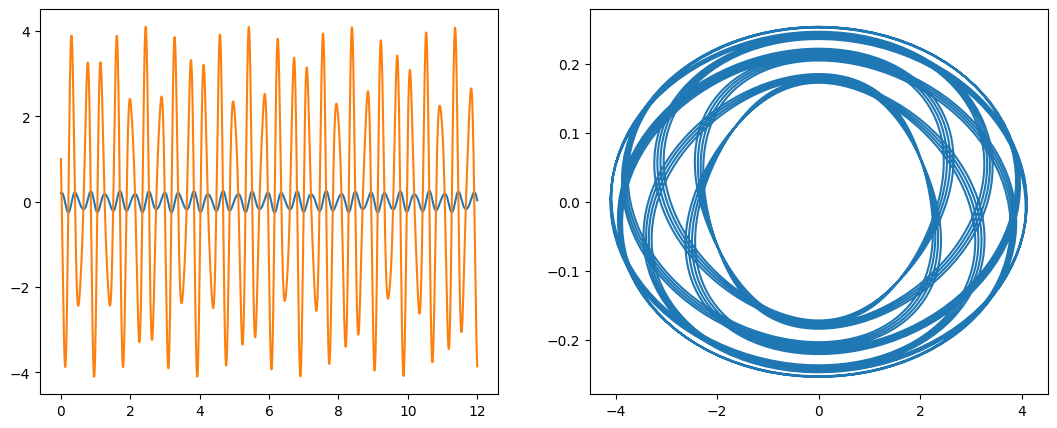

In [157]:
x1, vx1, x2, vx2 = solution.y

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(solution.t, x1)
ax[0].plot(solution.t, vx1)
ax[1].plot(vx1, x1)

In [158]:
def get_energies(solver_result: sc.integrate._ivp.ivp.OdeResult,
                 mass1: float, mass2: float,
                 k_1: float, k_2: float, k_3: float):
    
    t = sp.symbols('t')  # time
    m1, m2, k1, k2, k3 = sp.symbols('m1 m2 k1 k2 k3')       
    x1, x2  = sp.symbols('x1 x2', cls=sp.Function)     
    x1, x2 = x1(t), x2(t)
    vx1, vx2 = sp.diff(x1, t), sp.diff(x2, t)
    x1_dot, x2_dot = vx1, vx2
    y1, y2 = 0, 0
    vy1, vy2 = sp.diff(y1,t), sp.diff(y2,t)
    
    
    T_1 = sp.Rational(1,2) * m1 * (vx1**2 + vy1**2)
    T_2 = sp.Rational(1,2) * m2 * (vx2**2 + vy2**2)
    T = T_1 + T_2 
    
    U_1 = sp.Rational(1,2) * k1 * x1 ** 2
    U_2 = sp.Rational(1,2) * k2 * (x2 - x1) ** 2
    U_3 = sp.Rational(1,2) * k3 * x2 ** 2
    U = U_1 + U_2 + U_3
    
    # Lambdify the energy expressions
    T_func = sp.lambdify([m1, m2,
                          k1, k2, k3,
                          x1, x2,
                          x1_dot, x2_dot], T, 'numpy')
    
    U_func = sp.lambdify([m1, m2,
                          k1, k2, k3,
                          x1, x2,
                          x1_dot, x2_dot], U, 'numpy')

    # Extract the solver's results
    x_1_vals, vx_1_vals, x_2_vals, vx_2_vals = solver_result.y

    # Calculate energies
    kinetic_energies = T_func(mass1, mass2,
                              k_1, k_2, k_3,
                              x_1_vals, x_2_vals,
                              vx_1_vals, vx_2_vals)
    
    potential_energies = U_func(mass1, mass2,
                                k_1, k_2, k_3,
                                x_1_vals, x_2_vals,
                                vx_1_vals, vx_2_vals)

    return kinetic_energies, potential_energies



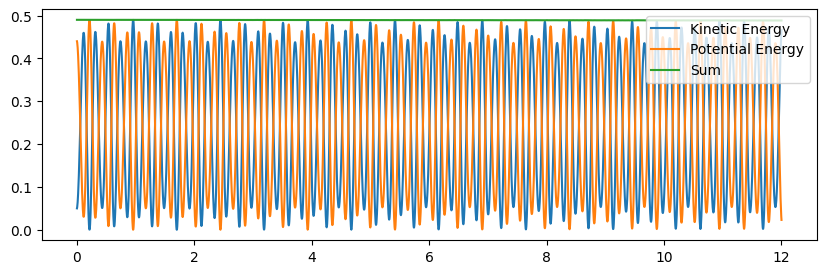

In [159]:
kinetic_energies, potential_energies = get_energies(solver_result=solution,
                                                    mass1=m1,
                                                    mass2=m2,
                                                    k_1=k1,
                                                    k_2=k2,
                                                    k_3=k3)

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(solution.t, kinetic_energies, label='Kinetic Energy')
ax.plot(solution.t, potential_energies, label='Potential Energy')
ax.plot(solution.t, potential_energies+kinetic_energies, label='Sum')
ax.legend(loc=1)
plt.show()


In [160]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# Parameters
cart_length_1, cart_length_2 = 0.5, 0.5
cart_height_1, cart_height_2 = 0.25, 0.25
cart_wheel_radius_1, cart_wheel_radius_2 = 0.075, 0.075
spring_length_1, spring_length_2, spring_length_3 = 1, 1, 1
track_length = spring_length_1 + cart_length_1 + spring_length_2 + cart_length_2 + spring_length_3

spring_amplitude = 0.125

# Getting values from solver
x_1_vals, vx_1_vals, x_2_vals, vx_2_vals = solution.y
times = solution.t

# Create a tqdm progress bar
pbar = tqdm(total=len(times))

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(5, 5))

# Set axis limits
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)

# Initialize carts
cart1 = Cart(x_center=x_1_vals[0]+spring_length_1+cart_length_1/2, 
             width=cart_length_1, 
             height=cart_height_1, 
             wheel_radius=cart_wheel_radius_1)
cart2 = Cart(x_center=x_2_vals[0]+spring_length_2+cart_length_2/2, 
             width=cart_length_2, height=cart_height_2, 
             wheel_radius=cart_wheel_radius_2)

# Initialize springs with arbitrary ends, they will be updated in the animation function
spring_y = cart_height_1/2+cart_wheel_radius_1
spring1 = Spring(start=np.array([0, spring_y]), 
                 end=np.array([cart1.x_center-cart_length_1/2, spring_y]),
                 amplitude=spring_amplitude)
spring2 = Spring(start=np.array([cart1.x_center+cart_length_1/2, spring_y]), 
                 end=np.array([cart2.x_center-cart_length_2/2, spring_y]),
                 amplitude=spring_amplitude)
spring3 = Spring(start=np.array([cart2.x_center+cart_length_2/2, spring_y]), 
                 end=np.array([track_length, spring_y]),
                 amplitude=spring_amplitude)  # Assuming right wall is at x=track_length

# Animation update function
def update(frame):
    # Update positions of carts
    cart1.x_center = x_1_vals[frame]+spring_length_1+cart_length_1/2
    cart2.x_center = x_2_vals[frame]+spring_length_1+cart_length_1+spring_length_2+cart_length_2/2
        
    # Update positions of springs based on the carts' positions
    spring1.end = np.array([cart1.x_center - cart_length_1/2, spring_y])
    spring2.start = np.array([cart1.x_center + cart_length_1/2, spring_y])
    spring2.end = np.array([cart2.x_center - cart_length_2/2, spring_y])
    spring3.start = np.array([cart2.x_center + cart_length_2/2, spring_y])

    # Clear the axis
    ax.cla()
    
    # Set axis limits
    ax.set_xlim(-0.1, track_length+0.1)
    ax.set_ylim(-0.1, track_length+0.1)
    ax.set_aspect('equal')
    
    # Redraw carts
    cart1.plot(ax)
    cart2.plot(ax)

    # Draw springs
    x_coords, y_coords = spring1.get_points()
    ax.plot(x_coords, y_coords, 'b-')

    x_coords, y_coords = spring2.get_points()
    ax.plot(x_coords, y_coords, 'g-')

    x_coords, y_coords = spring3.get_points()
    ax.plot(x_coords, y_coords, 'r-')
    
    # Plotting track
    ax.hlines(0, 0, track_length+0.1, lw=2, color='k')
    ax.vlines(0, 0, cart_wheel_radius_1+cart_height_1+0.1, lw=2, color='k')
    ax.vlines(track_length, 0, cart_wheel_radius_1+cart_height_1+0.1, lw=2, color='k')
    # Update the progress bar
    pbar.update(1)

    return ax,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(times), blit=False, interval=1)

# Set up the writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=200, metadata=dict(artist='Sebastian Yde'))

# Save the animation
ani.save('cart_springs_animation.mp4', writer=writer)

# Close the progress bar and the plot
pbar.close()
plt.close(fig)


3001it [02:09, 23.19it/s]                          
